# 🧠 OASIS – Clasificación de Alzheimer con XGBoost

Este notebook implementa modelos de clasificación usando **XGBoost** para detectar Alzheimer en etapas tempranas a partir de características extraídas de imágenes de resonancia magnética del dataset OASIS.

## Objetivos
- **Clasificación multiclase**: Distinguir entre CN (Cognitivamente Normal), MCI (Deterioro Cognitivo Leve) y AD (Alzheimer)
- **Clasificación binaria**: Detectar si un paciente tiene deterioro cognitivo (MCI/AD) vs normal (CN)

## Pipeline
1. Carga del dataset de features extraídas
2. Preparación de datos (features y etiquetas)
3. División en conjuntos de entrenamiento, validación y prueba
4. Manejo de desbalance de clases
5. Entrenamiento de modelos XGBoost (multiclase y binario)
6. Evaluación de rendimiento
7. Guardado de modelos entrenados

## 1. Carga de datos

En esta sección cargamos las librerías necesarias y el dataset de características preprocesadas.

**Librerías utilizadas:**
- `pandas`, `numpy`: Manipulación de datos
- `matplotlib`, `seaborn`: Visualización
- `sklearn`: División de datos, métricas y preprocesamiento
- `xgboost`: Modelo de clasificación basado en árboles de decisión

El dataset contiene **features numéricas** extraídas de imágenes de MRI (grilla 16×16, proxies anatómicos, texturas, etc.) junto con las etiquetas de clase (CN, MCI, AD).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

CSV_PATH = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\features_oasis_coronal.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()

Shape: (35256, 534)


,filepath,label,f_168,f_170,f_136,f_204,f_202,f_270,f_182,f_300,f_332,f_164,f_364,f_166,f_200,f_302,f_102,f_212,f_172,f_167,f_210,f_372,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_165,f_169,f_171,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,f_196,f_197,f_198,f_199,f_201,f_203,f_205,f_206,f_207,f_208,f_209,f_211,f_213,f_214,f_215,f_216,f_217,f_218,f_219,f_220,f_221,f_222,f_223,f_224,f_225,f_226,f_227,f_228,f_229,f_230,f_231,f_232,f_233,f_234,f_235,f_236,f_237,f_238,f_239,f_240,f_241,f_242,f_243,f_244,f_245,f_246,f_247,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,f_256,f_257,f_258,f_259,f_260,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,f_301,f_303,f_304,f_305,f_306,f_307,f_308,f_309,f_310,f_311,f_312,f_313,f_314,f_315,f_316,f_317,f_318,f_319,f_320,f_321,f_322,f_323,f_324,f_325,f_326,f_327,f_328,f_329,f_330,f_331,f_333,f_334,f_335,f_336,f_337,f_338,f_339,f_340,f_341,f_342,f_343,f_344,f_345,f_346,f_347,f_348,f_349,f_350,f_351,f_352,f_353,f_354,f_355,f_356,f_357,f_358,f_359,f_360,f_361,f_362,f_363,f_365,f_366,f_367,f_368,f_369,f_370,f_371,f_373,f_374,f_375,f_376,f_377,f_378,f_379,f_380,f_381,f_382,f_383,f_384,f_385,f_386,f_387,f_388,f_389,f_390,f_391,f_392,f_393,f_394,f_395,f_396,f_397,f_398,f_399,f_400,f_401,f_402,f_403,f_404,f_405,f_406,f_407,f_408,f_409,f_410,f_411,f_412,f_413,f_414,f_415,f_416,f_417,f_418,f_419,f_420,f_421,f_422,f_423,f_424,f_425,f_426,f_427,f_428,f_429,f_430,f_431,f_432,f_433,f_434,f_435,f_436,f_437,f_438,f_439,f_440,f_441,f_442,f_443,f_444,f_445,f_446,f_447,f_448,f_449,f_450,f_451,f_452,f_453,f_454,f_455,f_456,f_457,f_458,f_459,f_460,f_461,f_462,f_463,f_464,f_465,f_466,f_467,f_468,f_469,f_470,f_471,f_472,f_473,f_474,f_475,f_476,f_477,f_478,f_479,f_480,f_481,f_482,f_483,f_484,f_485,f_486,f_487,f_488,f_489,f_490,f_491,f_492,f_493,f_494,f_495,f_496,f_497,f_498,f_499,f_500,f_501,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,f_512,f_513,f_514,f_515,f_516,f_517,f_518,f_519,f_520,f_521,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,1.066037,0.372963,1.230763,0.754592,1.035331,0.164371,1.063728,0.452959,0.871066,0.514256,1.073424,0.614338,0.297699,0.189767,0.831010,1.013629,-0.104940,0.521993,0.858599,0.534457,-1.013416,0.081918,-1.009376,0.091144,-1.016879,0.087303,-0.663185,0.733431,0.208236,1.610399,0.137128,1.331577,0.010265,1.046849,0.141746,1.001365,-0.009128,1.029428,0.138744,1.002397,-0.011553,1.029253,0.079872,1.290279,-0.205715,1.306989,-0.987212,0.099054,-1.022305,0.072332,-1.021266,0.073140,-0.997255,0.069953,-0.950504,0.143440,0.354031,1.612340,0.549002,1.527892,-0.160926,0.470277,0.066828,0.582928,-0.187130,0.558981,-0.117753,0.497350,-0.269666,0.418861,0.247600,0.593992,-0.156539,0.544719,-0.322766,0.500792,-0.126180,1.037244,0.576129,1.474768,-0.742374,0.719865,-1.045507,0.065767,-0.981441,0.137044,0.592636,1.398538,0.101574,1.228630,-0.302334,0.36

## Distribución de clases

Analizamos la distribución de las clases en el dataset para entender el desbalance. Esto es importante porque:
- **CN** (Cognitivamente Normal): Generalmente la clase más numerosa
- **MCI** (Deterioro Cognitivo Leve): Clase intermedia
- **AD** (Alzheimer): Generalmente la clase menos numerosa

El desbalance puede afectar el rendimiento del modelo, por lo que aplicaremos técnicas de balanceo más adelante.

In [2]:
df['label'].value_counts().to_frame('count').assign(
    pct=lambda d: 100*d['count']/d['count'].sum()
)

,count,pct
label,,
MCI,18118,51.389834
CN,10626,30.139551
AD,6512,18.470615


## 2. Definir features y etiquetas

Preparamos los datos para el entrenamiento:

1. **Features (X)**: Seleccionamos todas las columnas que empiezan con `f_` (features numéricas extraídas)
2. **Etiquetas (y)**: Convertimos las etiquetas categóricas (CN, MCI, AD) a valores numéricos usando `LabelEncoder`:
   - CN → 0
   - MCI → 1
   - AD → 2

Esto es necesario porque XGBoost requiere etiquetas numéricas para la clasificación multiclase.

In [3]:
feature_cols=[c for c in df.columns if c.startswith('f_')]
X=df[feature_cols].values
y_labels=df['label'].values

le=LabelEncoder()
y_multi=le.fit_transform(y_labels)
dict(zip(le.classes_, le.transform(le.classes_)))

{'AD': np.int64(0), 'CN': np.int64(1), 'MCI': np.int64(2)}

## 3. Split Train / Val / Test

Dividimos el dataset en tres conjuntos:

1. **Training (70%)**: Para entrenar el modelo
2. **Validation (15%)**: Para ajustar hiperparámetros y monitorear el entrenamiento
3. **Test (15%)**: Para evaluar el rendimiento final (no se usa durante el entrenamiento)

Usamos `stratify` para mantener la proporción de clases en cada conjunto, lo cual es crucial dado el desbalance del dataset.

**Guardado de conjuntos:**
Los conjuntos divididos se guardan automáticamente en `data/splits/` como archivos `.npy` (numpy) para poder cargarlos posteriormente sin necesidad de volver a dividir el dataset:
- `X_train.npy`, `X_val.npy`, `X_test.npy` (features)
- `y_train.npy`, `y_val.npy`, `y_test.npy` (etiquetas)

In [4]:
X_train,X_temp,y_train,y_temp=train_test_split(
    X,y_multi,test_size=0.3,stratify=y_multi,random_state=42)

X_val,X_test,y_val,y_test=train_test_split(
    X_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Guardar los conjuntos en data/splits
BASE_DIR = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria"
SPLITS_DIR = os.path.join(BASE_DIR, "data", "splits")
os.makedirs(SPLITS_DIR, exist_ok=True)

# Guardar features (X)
np.save(os.path.join(SPLITS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SPLITS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(SPLITS_DIR, "X_test.npy"), X_test)

# Guardar etiquetas (y)
np.save(os.path.join(SPLITS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SPLITS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(SPLITS_DIR, "y_test.npy"), y_test)

print(f"\n✓ Conjuntos guardados en: {SPLITS_DIR}")
print("  - X_train.npy, X_val.npy, X_test.npy")
print("  - y_train.npy, y_val.npy, y_test.npy")

Shapes: (24679, 532) (5288, 532) (5289, 532)

✓ Conjuntos guardados en: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\splits
  - X_train.npy, X_val.npy, X_test.npy
  - y_train.npy, y_val.npy, y_test.npy


## 3.1. Manejo de desbalance

Calculamos **pesos de clase** para compensar el desbalance:

**Fórmula**: `peso_clase = total_muestras / (num_clases × muestras_clase)`

Esto hace que:
- Las clases minoritarias (AD) tengan **mayor peso** durante el entrenamiento
- Las clases mayoritarias (CN) tengan **menor peso**

XGBoost usará estos pesos (`sample_weight`) para dar más importancia a las muestras de clases desbalanceadas, mejorando la capacidad del modelo para detectar casos raros pero importantes (como AD).

In [5]:
unique,counts=np.unique(y_train,return_counts=True)
class_weights={cls: len(y_train)/(len(unique)*cnt) for cls,cnt in zip(unique,counts)}

sample_weight_train=np.array([class_weights[c] for c in y_train])
sample_weight_val=np.array([class_weights[c] for c in y_val])

class_weights

{np.int64(0): np.float64(1.8048120520696211),
 np.int64(1): np.float64(1.1059872725643094),
 np.int64(2): np.float64(0.6486110016031958)}

## 4. Modelo XGBoost – Multiclase

Entrenamos un modelo XGBoost para **clasificación multiclase** (CN, MCI, AD).

**Hiperparámetros clave:**
- `n_estimators=400`: Número de árboles (más árboles = mejor rendimiento, pero más tiempo)
- `max_depth=5`: Profundidad máxima de cada árbol (previene sobreajuste)
- `learning_rate=0.01`: Tasa de aprendizaje (pasos pequeños = entrenamiento más estable)
- `subsample=0.8`: Usa 90% de muestras por árbol (reduce sobreajuste)
- `colsample_bytree=1.0`: Usa 90% de features por árbol (diversidad)
- `objective="multi:softprob"`: Clasificación multiclase con probabilidades
- `eval_metric="mlogloss"`: Métrica de evaluación (log-loss multiclase)

El modelo se entrena con los pesos calculados anteriormente para manejar el desbalance.

In [7]:
# Hiperparámetros optimizados obtenidos de la optimización de hiperparámetros
# Fuente: 5_HIPERPARAMETER_OPTIMIZATION_OASIS.ipynb
params_multi={
    "n_estimators":400,        # Default (era 400)
    "max_depth":5,              # Default (era 5)
    "learning_rate":0.1,        # Default (era 0.05)
    "subsample":0.8,            # Default (era 0.9)
    "colsample_bytree":1.0,     # Default (era 0.9)
    "objective":"multi:softprob",
    "num_class":len(le.classes_),
    "eval_metric":"mlogloss",
    "tree_method":"hist",
    "random_state":42,
}

xgb_multi=XGBClassifier(**params_multi)

xgb_multi.fit(
    X_train,y_train,
    sample_weight=sample_weight_train,
    eval_set=[(X_val,y_val)],
    sample_weight_eval_set=[sample_weight_val],
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## 4.1. Evaluación multiclase

Evaluamos el modelo multiclase en el conjunto de prueba:

1. **Predicciones**: Clase predicha para cada muestra
2. **Probabilidades**: Probabilidad de pertenecer a cada clase (CN, MCI, AD)
3. **Classification Report**: Muestra precisión, recall y F1-score por clase
4. **Matriz de confusión**: Visualiza los aciertos y errores del modelo
5. **ROC-AUC macro**: Área bajo la curva ROC promedio (mide capacidad de discriminación)

**Interpretación:**
- **Precisión**: De los casos predichos como X, ¿cuántos realmente son X?
- **Recall**: De los casos reales de X, ¿cuántos detectó el modelo?
- **F1-score**: Balance entre precisión y recall

              precision    recall  f1-score   support

          AD       1.00      0.99      0.99       977
          CN       0.91      0.90      0.90      1594
         MCI       0.94      0.95      0.94      2718

    accuracy                           0.94      5289
   macro avg       0.95      0.94      0.95      5289
weighted avg       0.94      0.94      0.94      5289



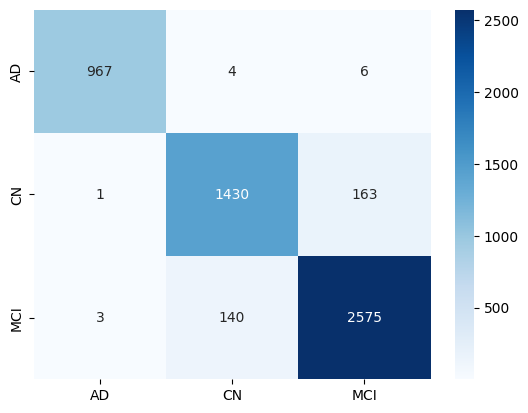

ROC-AUC macro: 0.9901585277105914


In [8]:
y_pred=xgb_multi.predict(X_test)
y_proba=xgb_multi.predict_proba(X_test)

print(classification_report(y_test,y_pred,target_names=le.classes_))

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=le.classes_,yticklabels=le.classes_)
plt.show()

try:
    print("ROC-AUC macro:", roc_auc_score(y_test,y_proba,multi_class='ovr'))
except:
    print("No se pudo calcular ROC multiclase.")

## 5. Modelo binario – CN vs MCI+AD

Entrenamos un segundo modelo para **clasificación binaria**:

- **Clase 0 (CN)**: Cognitivamente Normal
- **Clase 1 (MCI/AD)**: Cualquier forma de deterioro cognitivo

**¿Por qué un modelo binario?**
- A veces es más útil detectar si hay **cualquier deterioro** vs normalidad
- Puede tener mejor rendimiento al simplificar el problema
- Útil para screening inicial donde el objetivo es identificar pacientes que requieren atención

El proceso es similar al multiclase, pero con `objective="binary:logistic"` y pesos recalculados para las dos clases.

In [10]:
y_binary=(df['label']!='CN').astype(int).values

X_train_b,X_temp_b,y_train_b,y_temp_b=train_test_split(
    X,y_binary,test_size=0.3,stratify=y_binary,random_state=42)

X_val_b,X_test_b,y_val_b,y_test_b=train_test_split(
    X_temp_b,y_temp_b,test_size=0.5,stratify=y_temp_b,random_state=42)

# Calcular scale_pos_weight para mejorar recall (obtenido de la optimización)
pos_count = np.sum(y_train_b == 1)
neg_count = np.sum(y_train_b == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

params_bin={
    "n_estimators":400,         # Optimizado (mantiene 400)
    "max_depth":5,              # Optimizado (era 5)
    "learning_rate":0.1,        # Optimizado (era 0.05)
    "subsample":0.8,            # Optimizado (mantiene 0.9)
    "colsample_bytree":0.8,     # Optimizado (mantiene 0.9)
    "scale_pos_weight":scale_pos_weight,  # Optimizado para mejorar recall (≈1.429)
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "tree_method":"hist",
    "random_state":42,
}

print(f"scale_pos_weight calculado: {scale_pos_weight:.3f}")
print("Hiperparámetros optimizados aplicados para mejorar recall")

xgb_bin=XGBClassifier(**params_bin)

# Nota: scale_pos_weight ya está incluido en params_bin, no necesitamos sample_weight adicional
xgb_bin.fit(
    X_train_b,y_train_b,
    eval_set=[(X_val_b,y_val_b)],
    verbose=False
)

scale_pos_weight calculado: 0.431
Hiperparámetros optimizados aplicados para mejorar recall


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 5.1. Evaluación binaria

Evaluamos el modelo binario:

1. **Predicciones**: 0 (CN) o 1 (MCI/AD)
2. **Probabilidades**: Probabilidad de pertenecer a la clase positiva (MCI/AD)
3. **Classification Report**: Métricas para ambas clases
4. **Matriz de confusión**: Muestra verdaderos/falsos positivos y negativos
5. **ROC-AUC**: Área bajo la curva ROC (mide qué tan bien distingue entre CN y MCI/AD)

**Interpretación de la matriz de confusión:**
- **Verdaderos Negativos (CN→CN)**: Correctamente identificados como normales
- **Falsos Positivos (CN→MCI/AD)**: Falsas alarmas (normal clasificado como deterioro)
- **Falsos Negativos (MCI/AD→CN)**: Casos perdidos (deterioro clasificado como normal) ⚠️ **CRÍTICO**
- **Verdaderos Positivos (MCI/AD→MCI/AD)**: Correctamente detectados como deterioro

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.95      0.95      0.95        37

    accuracy                           0.96        90
   macro avg       0.95      0.95      0.95        90
weighted avg       0.96      0.96      0.96        90



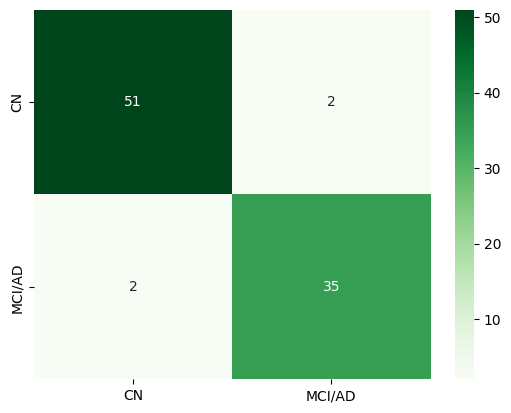

0.9872514023457419

In [10]:
y_pred_b=xgb_bin.predict(X_test_b)
y_proba_b=xgb_bin.predict_proba(X_test_b)[:,1]

print(classification_report(y_test_b,y_pred_b))

cm_b=confusion_matrix(y_test_b,y_pred_b)
sns.heatmap(cm_b,annot=True,fmt='d',cmap='Greens',
            xticklabels=['CN','MCI/AD'],yticklabels=['CN','MCI/AD'])
plt.show()

roc_auc_score(y_test_b,y_proba_b)

## 6. Guardar modelos

Guardamos los modelos entrenados en formato JSON para uso posterior:

1. **xgb_multiclass_oasis.json**: Modelo para clasificación CN/MCI/AD
2. **xgb_binary_oasis.json**: Modelo para clasificación CN vs MCI/AD

**Uso futuro:**
Los modelos guardados pueden cargarse con `XGBClassifier.load_model()` para hacer predicciones en nuevos datos sin necesidad de reentrenar.

**Nota**: Asegúrate de que la carpeta `models` exista o se creará automáticamente.

In [ ]:
BASE_DIR = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria"
MODEL_DIR = os.path.join(BASE_DIR, "models_saved")
os.makedirs(MODEL_DIR, exist_ok=True)

xgb_multi.save_model(os.path.join(MODEL_DIR, "xgb_multiclass_oasis_hiperparameter.json"))
xgb_bin.save_model(os.path.join(MODEL_DIR, "xgb_binary_oasis_hiperparameter.json"))

print("Modelos guardados en carpeta 'models_saved'")

Modelos guardados en carpeta 'models_saved'


: 